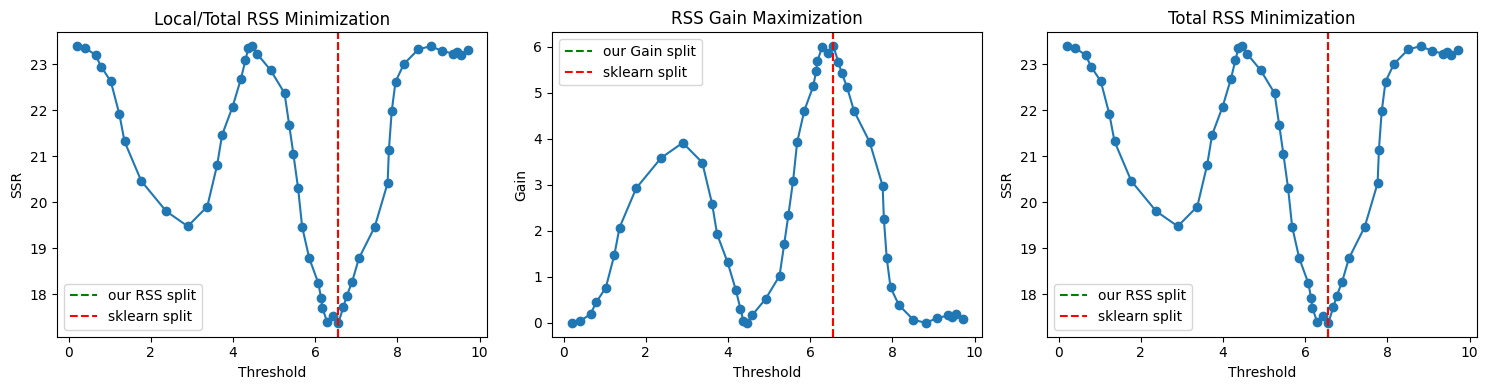

 Threshold |        SSR |  Threshold |       Gain |  Threshold |        SSR
--------------------------------------------------------------------------
     0.195 |    23.3888 |      0.195 |     0.0023 |      0.195 |    23.3888
     0.402 |    23.3491 |      0.402 |     0.0420 |      0.402 |    23.3491
     0.656 |    23.1992 |      0.656 |     0.1919 |      0.656 |    23.1992
     0.791 |    22.9459 |      0.791 |     0.4453 |      0.791 |    22.9459
     1.027 |    22.6256 |      1.027 |     0.7655 |      1.027 |    22.6256
     1.236 |    21.9111 |      1.236 |     1.4800 |      1.236 |    21.9111
     1.361 |    21.3204 |      1.361 |     2.0707 |      1.361 |    21.3204
     1.769 |    20.4628 |      1.769 |     2.9284 |      1.769 |    20.4628
     2.375 |    19.8059 |      2.375 |     3.5852 |      2.375 |    19.8059
     2.900 |    19.4788 |      2.900 |     3.9123 |      2.900 |    19.4788
     3.375 |    19.9079 |      3.375 |     3.4832 |      3.375 |    19.9079
     3.616 | 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# 1) RSS function
def compute_ssr(y):
    mean_y = np.mean(y)
    return np.sum((y - mean_y) ** 2)

# 2) Local RSS / Total RSS split
def find_best_split_rss(X, y):
    best_ssr = float('inf')
    best_thr = None
    for i in range(1, len(X)):
        if X[i] == X[i-1]:
            continue
        t = 0.5 * (X[i-1] + X[i])
        ssr = compute_ssr(y[X < t]) + compute_ssr(y[X >= t])
        if ssr < best_ssr:
            best_ssr, best_thr = ssr, t
    return best_thr, best_ssr

# 3) RSS gain split (equivalent to local RSS)
def find_best_split_gain(X, y):
    parent = compute_ssr(y)
    best_gain = -np.inf
    best_thr = None
    for i in range(1, len(X)):
        if X[i] == X[i-1]:
            continue
        t = 0.5 * (X[i-1] + X[i])
        gain = parent - (compute_ssr(y[X < t]) + compute_ssr(y[X >= t]))
        if gain > best_gain:
            best_gain, best_thr = gain, t
    return best_thr, best_gain

# 4) synthetic data
np.random.seed(0)
X = np.sort(np.random.rand(50) * 10)
y = np.sin(X) + np.random.normal(0, 0.1, 50)

# 5) splits with our functions
thr_rss, val_rss = find_best_split_rss(X, y)
thr_gain, val_gain = find_best_split_gain(X, y)

# 6) sklearn check
dt = DecisionTreeRegressor(max_depth=1, random_state=0)
dt.fit(X.reshape(-1,1), y)
sk_thr = dt.tree_.threshold[0]

# arrays of thresholds, SSR and Gain values
uniq = np.unique(X)
thrs = 0.5 * (uniq[:-1] + uniq[1:])
ssr_vals = np.array([compute_ssr(y[X < t]) + compute_ssr(y[X >= t]) for t in thrs])
gain_vals = compute_ssr(y) - ssr_vals

# 7) Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 7.1) Local RSS minimization
axes[0].plot(thrs, ssr_vals, 'o-')
axes[0].axvline(thr_rss, color='green', linestyle='--', label='our RSS split')
axes[0].axvline(sk_thr, color='red', linestyle='--', label='sklearn split')
axes[0].set_title('Local/Total RSS Minimization')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('SSR')
axes[0].legend()

# 7.2) RSS Gain maximization
axes[1].plot(thrs, gain_vals, 'o-')
axes[1].axvline(thr_gain, color='green', linestyle='--', label='our Gain split')
axes[1].axvline(sk_thr, color='red', linestyle='--', label='sklearn split')
axes[1].set_title('RSS Gain Maximization')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Gain')
axes[1].legend()

# 7.3) Total RSS minimization
axes[2].plot(thrs, ssr_vals, 'o-')
axes[2].axvline(thr_rss, color='green', linestyle='--', label='our RSS split')
axes[2].axvline(sk_thr, color='red', linestyle='--', label='sklearn split')
axes[2].set_title('Total RSS Minimization')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('SSR')
axes[2].legend()

plt.tight_layout()
plt.show()

# 8) Print thresholds
print(f"{'Threshold':>10} | {'SSR':>10} | {'Threshold':>10} | {'Gain':>10} | {'Threshold':>10} | {'SSR':>10}")
print("-"*74)
for i, t in enumerate(thrs):
    print(f"{t:10.3f} | {ssr_vals[i]:10.4f} | {t:10.3f} | {gain_vals[i]:10.4f} | {t:10.3f} | {ssr_vals[i]:10.4f}")

# 9) Print splits
print(" RSS split:    ", thr_rss)
print(" Gain split:   ", thr_gain)
print("sklearn split:    ", sk_thr)


W drzewie decyzyjnym każdy liść odpowiada $R_m$ w przestrzeni cech:

$$
R_m = \{\, i \,\mid\, x_i \text{ ends in leaf } m\}
$$

Dla $x_i\in R_m$ przewidywana wartość to stała  

$$
\hat y_{R_m}= \frac{1}{|R_m|}\sum_{i:x_i\in R_m}y_i
$$


Dla progu $t$:

$$
RSS_L(t)=\sum_{x_i<t}(y_i-\bar y_L)^2,\qquad
RSS_R(t)=\sum_{x_i\ge t}(y_i-\bar y_R)^2,
$$
$$
RSS(t)=RSS_L(t)+RSS_R(t)
$$

$$
Gain(t)=RSS_{\text{parent}}
-\bigl[RSS_L(t)+RSS_R(t)\bigr]
=\text{const}-RSS(t).
$$
gdzie:

$$
RSS_{\text{parent }}
=\sum_{i \in \text{Parent}}
\bigl(y_i-\bar y_{\text{parent }}\bigr)^2,
\qquad
\bar y_{\text{parent }}
=\frac{1}{|\text{Parent}|}
\sum_{i \in \text{Parent}} y_i.
$$
Czyli mamy stałą od której odejmujemy funkcję RSS, czyli to jest przekształcenie liniowe, z tego powodu wykres $\mathrm{Gain}(t)$ ma taki sam kształt co $\mathrm{RSS}(t)$, ale odwrócony względem osi "Threshold".

Niech
$$
f(t)=\mathrm{RSS}_L(t)+\mathrm{RSS}_R(t),
\quad
g(t)=C - f(t).
$$
gdzie $C=RSS_{\text{parent}}$.
Jeśli $t'=\arg\min f$, wtedy dla
$$
f(t)\ge f(t')
$$
mamy
$$C-f(t)\le C-f(t')
$$
wtedy
$$
t'=\arg\max g
$$
Czyli minimalizacja $f$ i maksymalizacja $g$ dają ten sam próg $t'$.



Total RSS Minimization
$$\left(X_j^*, t^*\right)=\arg \min _{\left(X_j, t\right)} \sum_{m \in \operatorname{Leaves}\left(T\left(X_j, t\right)\right)} \sum_{i \in R_m}\left(y_i-\bar{y}_{R_m}\right)^2=$$
$$
\min_t\Bigl[
  \underbrace{\sum_{\ell\neq\ell_0}RSS_\ell}_{\text{stała}}
  +\bigl(RSS_L(t)+RSS_R(t)\bigr)
\Bigr].
$$
gdzie błąd wszystkich pozostałych liści (oprócz $\ell_0$):  

$$
\sum_{\ell \neq \ell_0} R S S_{\ell}
=\sum_{\ell \neq \ell_0}\;
  \sum_{i \in R_\ell}
  \bigl(y_i-\bar y_{R_\ell}\bigr)^2
\qquad
\bar y_{R_\ell}
=\frac{1}{|R_\ell|}
 \sum_{i \in R_\ell} y_i
$$
więc "stała" nie zależy od $t$, więc wszystkie trzy wzory dają taki sam wynik oraz prowadzą do tego samego progu rozbicia.


